<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Simulated Realizations Post-processing

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy* [e-book]. Zenodo. doi:10.5281/zenodo.15169133 [![DOI](https://zenodo.org/badge/838927017.svg)](https://doi.org/10.5281/zenodo.15169132)  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository* (0.0.1) [Software]. Zenodo. doi:10.5281/zenodo.12667036. GitHub Repository: https://github.com/GeostatsGuy/GeostatsPyDemos [![DOI](https://zenodo.org/badge/777871341.svg)](https://doi.org/10.5281/zenodo.12667035)



```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **Simulated Realizations Post-processing** with GeostatsPy.

* with the simulation paradigm we calculate multiple realizations to represent uncertainty

* post-processing is a method to summarize over multiple realizations

**YouTube Lecture**: check out my lectures on:

* [Stochastic Simulation](https://youtu.be/3cLqK3lR56Y?si=3WhHX5QOZrrtlgAI)

* [Summarizing Uncertainty](https://youtu.be/j20UITevJc0?si=0F5po159U580VqGK)

For your convenience here's a summary of salient points.

#### Spatial Simulation

This method is critical for:

1. Prediction away from wells, e.g. pre-drill assessments, with uncertainty 
2. Spatial uncertainty modeling.
3. Heterogeneity realizations ready for application to the transfer function.

##### Sequential Gaussian Simulation

With sequential Gaussian simulation we build on kriging by:

* adding a random residual with the missing variance

* sequentially adding the simulated values as data to correct the covariance between the simulated values

The resulting model corrects the issues of kriging, as we now:

* reproduce the global feature PDF / CDF

* reproduce the global variogram

* while providing a model of uncertainty through multiple realizations

Here's a simple workflow for realization post-processing. Some examples of applications include:

* Quantifying local uncertainty away from wells
* Accessing the probability / risk of specific local outcomes

First let's explain the concept of realization post-processing.

#### Realization Post-processing

Post-processing refers to operations to provide summaries over multiple realizations.

Here we focus on a few local statistical summaries. These methods calculate the local cumulative distribution function at each location in the model based on pooling the local realizations.

$$
F_x(\bf{u}_{\alpha})
$$

The following are local summaries demonstrated in this workflow:

* **e-type** is the local expectation (since equal weighted the same as the average)

$$
e(\bf{u }_{\alpha}) = E \left[x^{\ell}(\bf{ u }_{\alpha}) \right], \quad \forall \quad \ell = 1., \ldots, L, \quad \alpha \in V
$$

* **conditional standard deviation** is the local standard deviation over the realizations

$$
\sigma(\bf{u }_{\alpha}) = \sqrt{E \left[ (x^{\ell}(\bf{u }_{\alpha})- e(\bf{u }_{\alpha}))^2 \right] }, \quad \forall \quad \ell = 1., \ldots, L, \quad \alpha \in V
$$

* **local percentile** is the local percentile over the realizations

$$
x^p(\bf{ u } _{\alpha}) = F^{-1}(p; \bf{u }_{\alpha}), \quad \alpha \in V
$$

* **local probability of exceedance** is the local percentile over the realizations

$$
P \{X(\bf{ u } _{\alpha}) \le x_k \} = 1 - \frac{1}{L} \cdot \sum^{L}_{\ell=1} i^{\ell}(\bf{ u } _{\alpha}; z_k), \quad \alpha \in V
$$

In this workflow we will calculate multiple realizations and then use each one of these local calculations over the realizations to demonstrate model post-processing.  

#### Load the Required Libraries

The following code loads the required libraries. 

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a convenience function for plotting the simulated realizations with data.

In [3]:
def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step))
    cs = plt.imshow(array,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)
    plt.scatter(df[xcol],df[ycol],s=20,c=df[vcol],marker='o',cmap=cmap,vmin=vmin,vmax=vmax,alpha=0.8,linewidths=0.8,edgecolors='black',zorder=2)
    plt.scatter(df[xcol],df[ycol],s=40,c='white',marker='o',alpha=0.8,linewidths=0.8,edgecolors=None,zorder=1)
    plt.title(title); plt.xlabel(xlabel)
    plt.ylabel(ylabel); plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    cbar = plt.colorbar(cs,orientation="vertical",cmap=cmap)
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("c:/PGE383")                                        # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extra a limited sample so that the spatial samples are not too dense.  This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # read a .csv file in as a DataFrame
df = df.sample(50)                                            # extract 50 samples
df = df.reset_index()                                         # reset the record index 
df = df[['X','Y','Porosity']]                                 # remove unnecessary features
df.head()

,X,Y,Porosity
0,410.0,499.0,0.119853
1,890.0,919.0,0.109401
2,680.0,689.0,0.095578
3,940.0,799.0,0.091960
4,790.0,19.0,0.117937


#### Set Limits for Plotting and Colorbars and Grid Specification

Limits are applied for data and model visualization and the grid parameters sets the coverage and resolution of our map.

In [6]:
xmin = 0.0; xmax = 1000.0                                     # spatial limits
ymin = 0.0; ymax = 1000.0

nx = 100; xmn = 5.0; xsiz = 10.0                              # grid specification
ny = 100; ymn = 5.0; ysiz = 10.0

pormin = 0.0; pormax = 0.22                                   # feature limits for plotting

tmin = -9999.9; tmax = 9999.9                                 # feature triming limits

nxdis = 1; nydis = 1                                          # block discretization
ndmin = 0; ndmax = 10                                         # min and max number of data and previously simulated nodes
ktype = 0; skmean = np.average(df['Porosity'].values)         # kriging type and global stationary mean / assume no bias 

#### Calculating Multiple Realizations

Let's calculate multiple realizations and visualize a few of them to check.  Note, we need enough realizations to be able to summarize the local uncertainties over the models.  I defaulted to 20, you can reduce this to improve the run time, but the results will be more noisy!

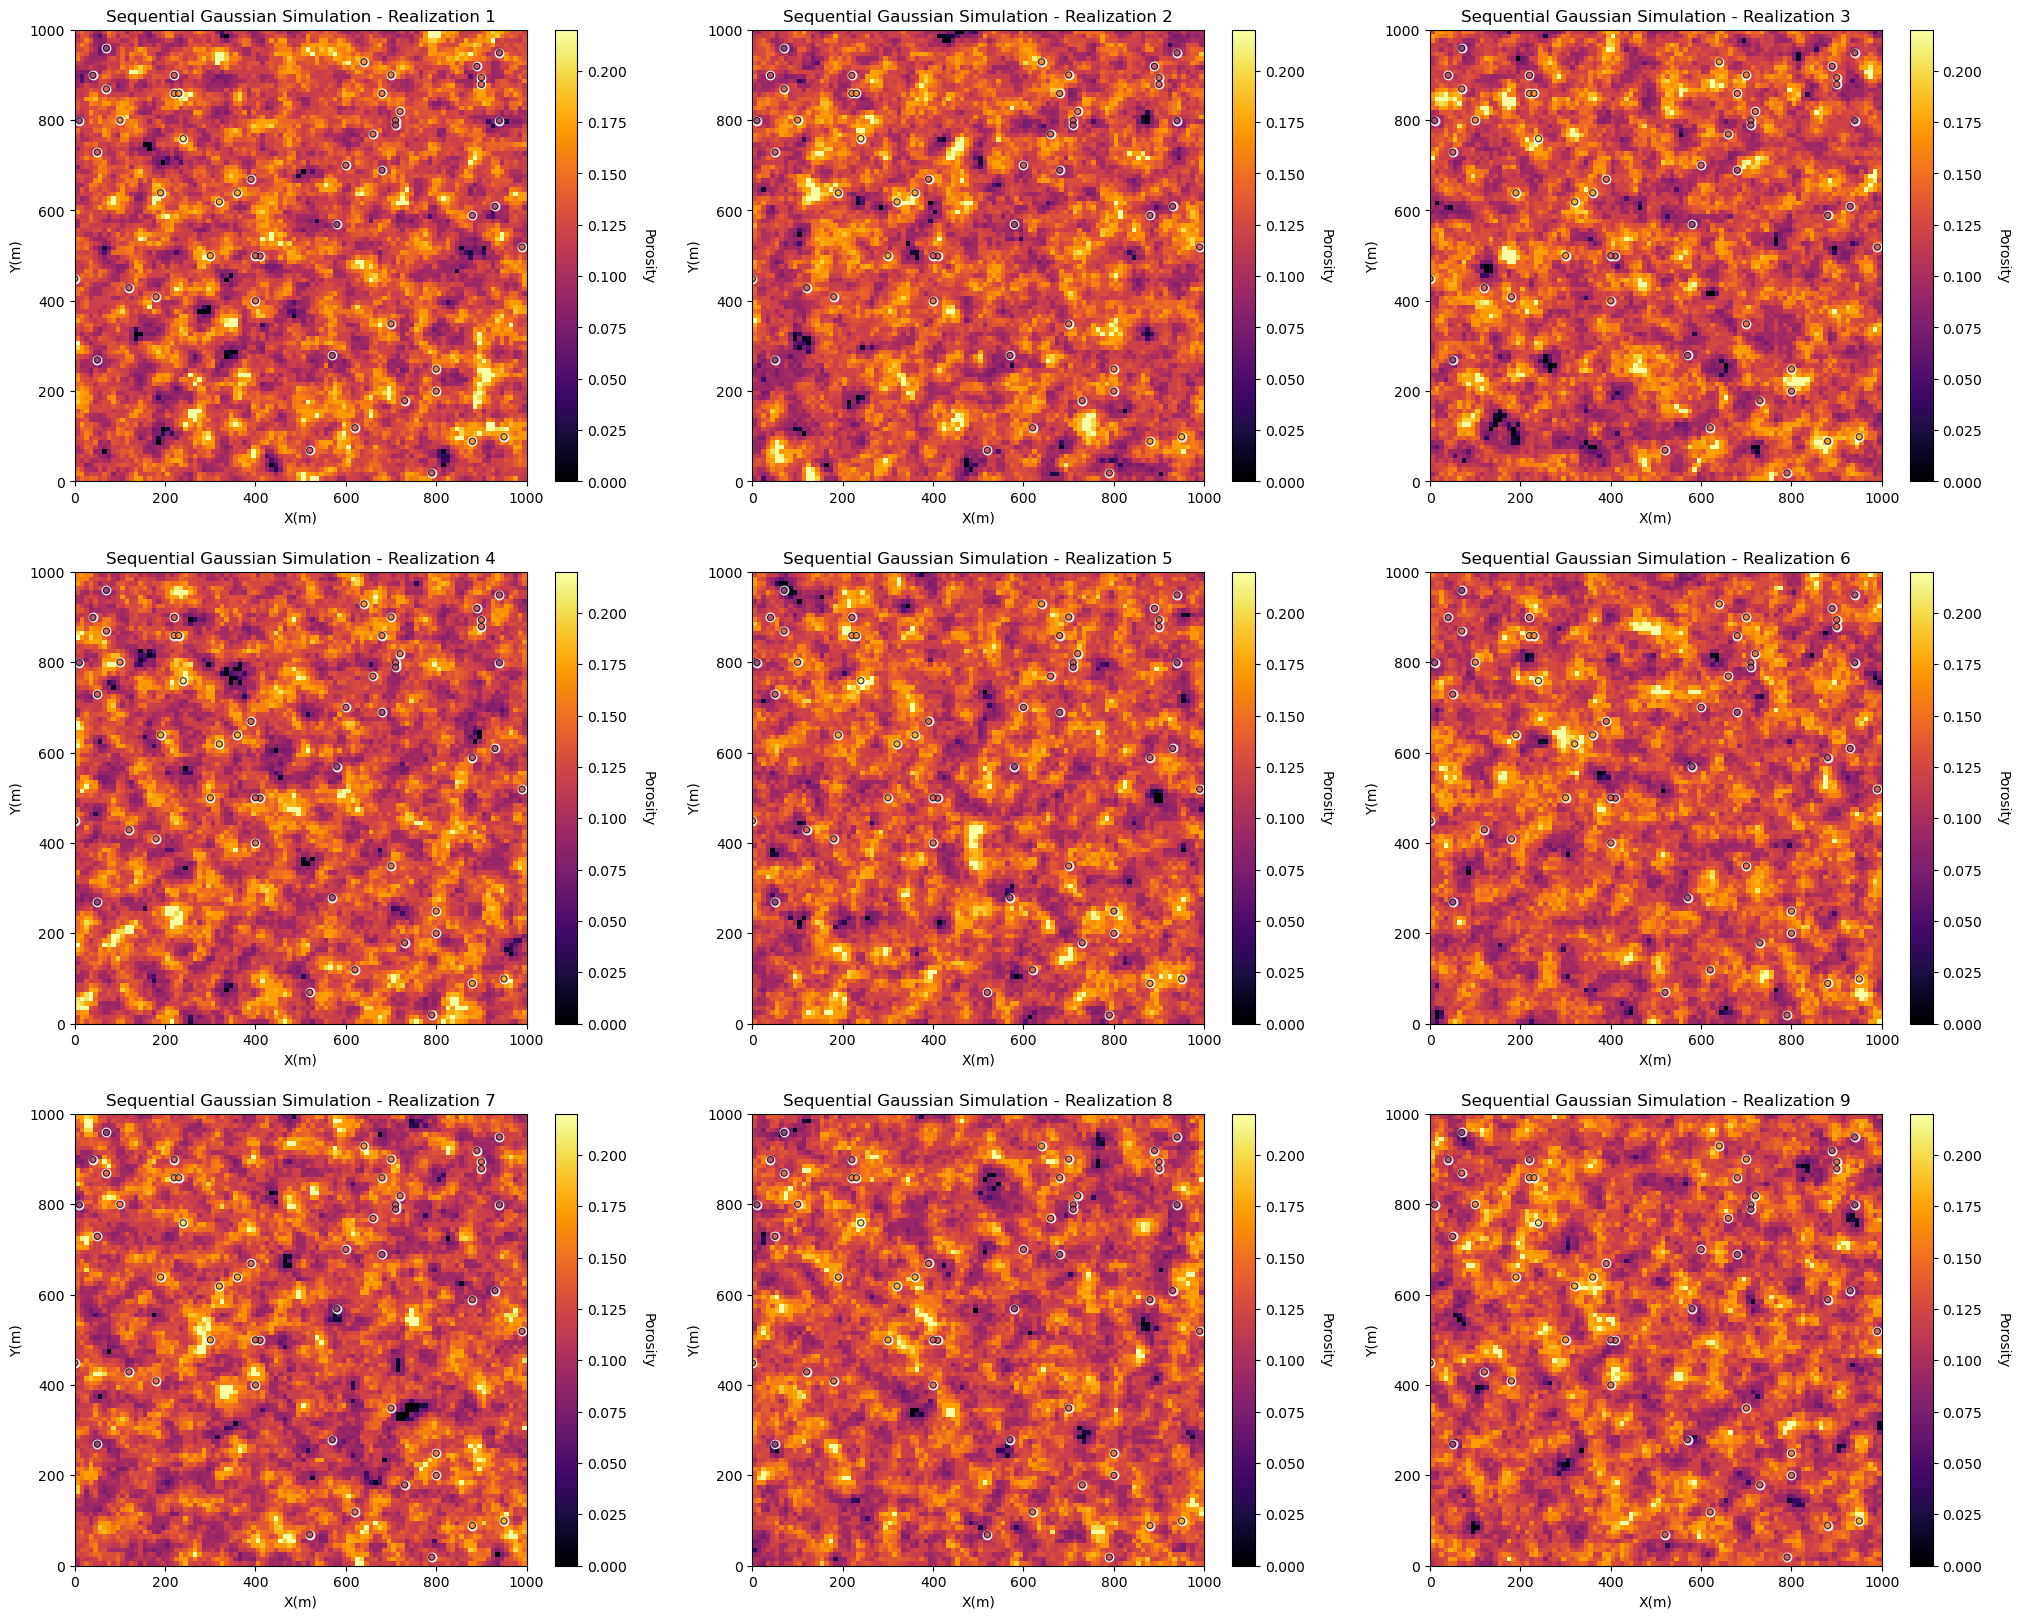

In [7]:
run = True                                                    # run the realizations, it will likely take minutes to complete

nreal = 9                                                     # number of realizations

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=50,hmin1=50)

if run == True:
    with io.capture_output() as captured:                     # mute simulation output
        realizations = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=nreal,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

for ireal in range(0,min(nreal,9)):
    plt.subplot(3,3,ireal+1)
    locpix_st(realizations[ireal],xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity',
        'Sequential Gaussian Simulation - Realization ' + str(ireal+1),'X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2); plt.show()

#### Summarizing Local Uncertainty with the POSTSIM Method

Let's run the POSTSIM algorithm. It simply loops over all the locations ix and iy and calculates local summary statistics to quantify the local uncertainty.

#### e-type and Conditional Variance

We will start with the e-type and the conditional variance.  

* **e-type** is the local expectation (just the average of the $L$ realizations at location $\bf{u}_{\alpha}$ as we assume all realizations are equally likely).
* **conditional variance** is the local variance  

Note, we just have to run the program once because both of these outputs are included together.

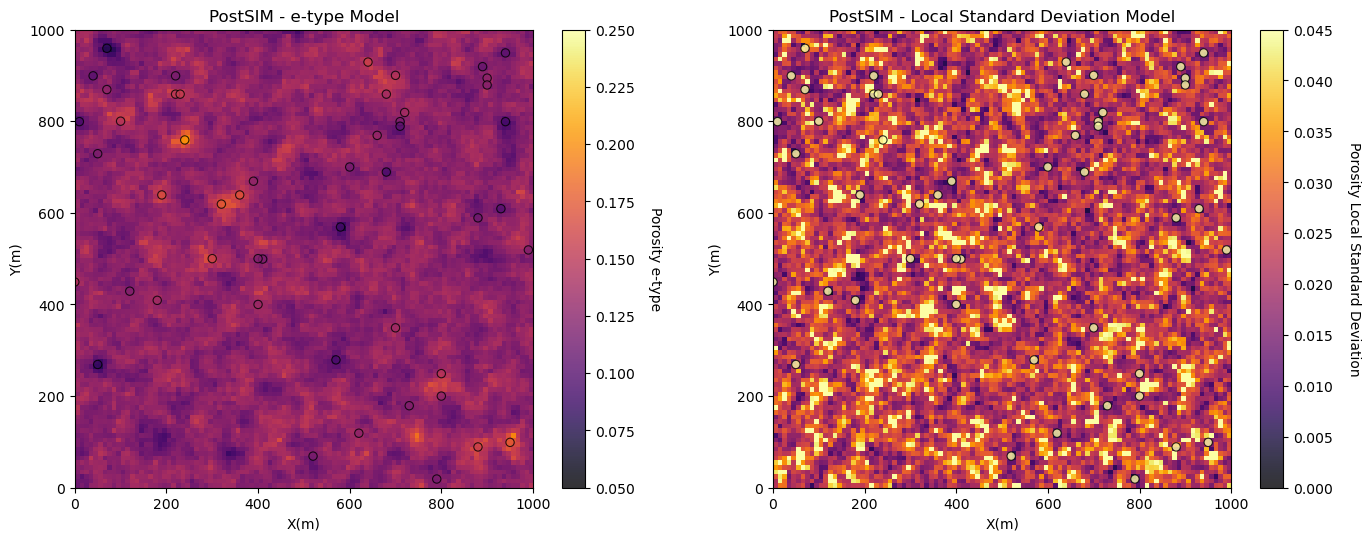

In [8]:
e_type = geostats.local_expectation(realizations)             # local expectation map
local_stdev = geostats.local_standard_deviation(realizations) # local standard deviation map

plt.subplot(2,2,1)
GSLIB.locpix_st(e_type,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','PostSIM - e-type Model','X(m)','Y(m)','Porosity e-type',cmap)

plt.subplot(2,2,2)
GSLIB.locpix_st(local_stdev,xmin,xmax,ymin,ymax,xsiz,0.0,0.045,df,'X','Y','Porosity','PostSIM - Local Standard Deviation Model','X(m)','Y(m)','Porosity Local Standard Deviation',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2)
plt.show()

The e-type model is very similar to a kriging model, except for:

* the Gaussian forward and back transform may change the results
* result are noisy due to too few realizations

The conditional variance is lowest at the data locations and increased away from the data

* the result is noisy due to too few realizations

#### Local Percentiles

Now let's look at the:

* **local percentile** maps are the maps with the local percentile values sampled from the local realizations

We can interpret them as follows, at a location if we have a local P10 of 14% porosity, then we have a 90% probability of an even higher porosity, the porosity at that location is surely high.

Local percentiles are very convenient to understand local uncertainty.  We must make sure that we do not mix them up with a percentile model (the model that is globally ranked as a specific percentile outcome.

Note: we have to run the program for each percentile, we specify this as the *cdf_value* input.

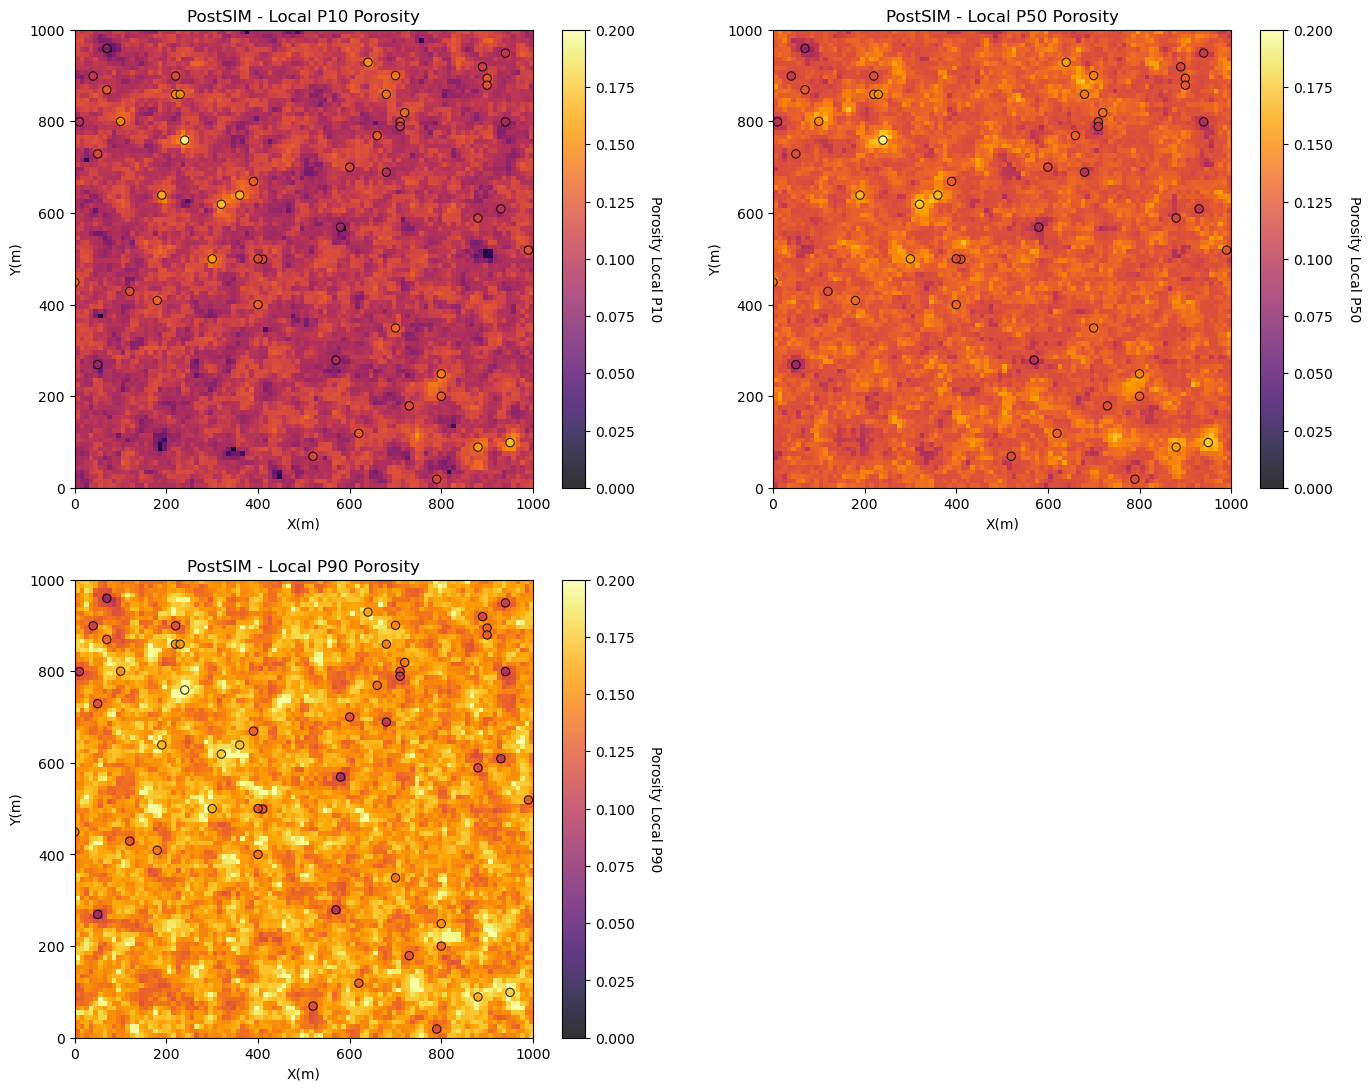

In [9]:
localp10 = geostats.local_percentile(realizations = realizations,p_value = 10) # local P10 map
localp50 = geostats.local_percentile(realizations = realizations,p_value = 50) # local P50 map
localp90 = geostats.local_percentile(realizations = realizations,p_value = 90) # local P90 map

plt.subplot(221)
GSLIB.locpix_st(localp10,xmin,xmax,ymin,ymax,xsiz,0.0,.2,df,'X','Y','Porosity','PostSIM - Local P10 Porosity','X(m)','Y(m)','Porosity Local P10',cmap)

plt.subplot(222)
GSLIB.locpix_st(localp50,xmin,xmax,ymin,ymax,xsiz,0.0,.2,df,'X','Y','Porosity','PostSIM - Local P50 Porosity','X(m)','Y(m)','Porosity Local P50',cmap)

plt.subplot(223)
GSLIB.locpix_st(localp90,xmin,xmax,ymin,ymax,xsiz,0.0,.2,df,'X','Y','Porosity','PostSIM - Local P90 Porosity','X(m)','Y(m)','Porosity Local P90',cmap)

plt.subplots_adjust(left=0.0,bottom=0.0,right=2.0,top=2.1,wspace=0.2,hspace=0.2); plt.show()

#### Probability of Exceedance

Now we will look at the: 

* **probability of exceedance** where we specify a threshold porosity value and calculate the probability of exceeding that value at all locations.

We will typically select critical thresholds, such as a net-to-gross threshold.

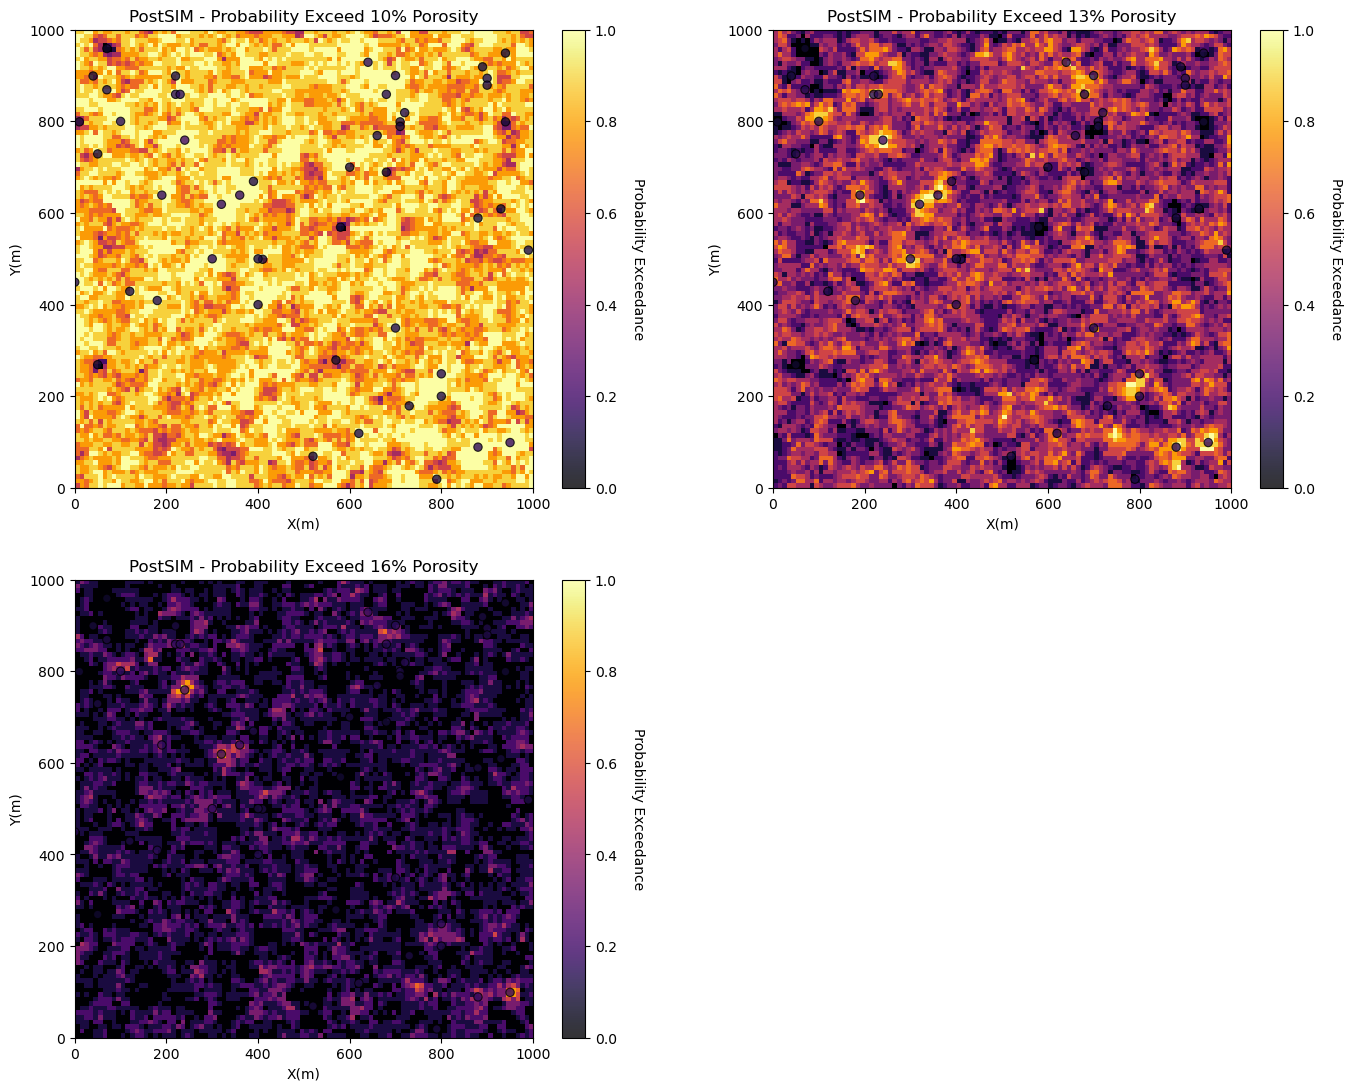

In [10]:
prob10 = geostats.local_probability_exceedance(realizations = realizations,threshold = 0.10) # local probability por > 0.10
prob13 = geostats.local_probability_exceedance(realizations = realizations,threshold = 0.13) # local probability por > 0.13
prob16 = geostats.local_probability_exceedance(realizations = realizations,threshold = 0.16) # local probability por > 0.16

plt.subplot(221)
GSLIB.locpix_st(prob10,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Probability Exceed 10% Porosity','X(m)',
                'Y(m)','Probability Exceedance',cmap)

plt.subplot(222)
GSLIB.locpix_st(prob13,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Probability Exceed 13% Porosity','X(m)',
                'Y(m)','Probability Exceedance',cmap)

plt.subplot(223)
GSLIB.locpix_st(prob16,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Probability Exceed 16% Porosity','X(m)',
                'Y(m)','Probability Exceedance',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration of summarization over realizations with GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### About the Author

<figure style="text-align: center;">
  <img src="_static/intro/michael_pyrcz_officeshot_jacket.jpg" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Professor Michael Pyrcz in his office on the 40 acres, campus of The University of Texas at Austin.
</figcaption>
</figure>

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)